In [1]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
def compute_optimal_transport(M, r, c, lam, epsilon=1e-5):
    """
    Computes the optimal transport matrix and Slinkhorn distance using the
    Sinkhorn-Knopp algorithm
    Inputs:
        - M : cost matrix (n x m)
        - r : vector of marginals (n, )
        - c : vector of marginals (m, )
        - lam : strength of the entropic regularization
        - epsilon : convergence parameter
    Output:
        - P : optimal transport matrix (n x m)
        - dist : Sinkhorn distance
    """
    n, m = M.shape
    P = np.exp(- lam * M)
    P /= P.sum()
    u = np.zeros(n)
    # normalize this matrix
    while np.max(np.abs(u - P.sum(1))) > epsilon:
        u = P.sum(1)
        P *= (r / u).reshape((-1, 1))
        P *= (c / P.sum(0)).reshape((1, -1))
    return P, np.sum(P * M)

In [47]:
"""
Created on Wednesday 18 October 2017
Last update: Thursday 19 October 2017

@author: Michiel Stock
michielfmstock@gmail.com

General class for optimal transport
"""

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.linear_model import RidgeCV
import numpy as np

class OptimalTransport(object):
    """
    General class for optimal transport on a set of points with a given
    distance.
    """
    def __init__(self, X1, X2, M=None, r=None, c=None, lam=10,
                        fit_mapping=False, distance_metric='euclidean'):
        super(OptimalTransport, self).__init__()
        # check if all densities are nonzero
        assert (r is None or np.all(r>0)) and (c is None or np.all(c>0))
        self.X1 = X1
        n1, p1 = X1.shape
        self.X2 = X2
        n2, p2 = X2.shape
        self.lam = lam
        if r is None:  # uniform weights
            self.r = np.ones(n1) / n1
        else:
            self.r = r
        if c is None:  # uniform weights
            self.c = np.ones(n2) / n2
        else:
            self.c = c
        # compute the distance matrix
        if M is None:  # compute distance matrix
            self.M = pairwise_distances(X1, X2, metric=distance_metric)
        else:
            self.M = M
        # compute the optimal transport mapping
        self.compute_optimal_transport(lam, fit_mapping)
        if fit_mapping:
            self.fit_mapping()


    def compute_optimal_transport(self, lam, fit_mapping=False):
        """
        (Re)computes the optimal transport matrix using the Skinkhorn-Knopp
        algorithm

        Inputs:
            - lam : the value of the entropic regularization
            - fit_mapping : fit the mappings from and to the distributions (default=False)
        """
        self.P, self.d = compute_optimal_transport(
                                            self.M,self.r, self.c,
                                            lam, epsilon=1e-6)
        if fit_mapping:
            self.fit_mapping()

    def fit_mapping(self):
        """
        Fits the mappings from one distributions to the other
        """
        X1 = self.X1
        n1, p1 = X1.shape
        X2 = self.X2
        n2, p2 = X2.shape
        P = self.P
        c = self.c
        r = self.r
        reg_mapping = self.reg_mapping
        # mapping from X1 to X2
        self.model1to2 = RidgeCV(alphas=np.logspace(-3, 3, 7))
        self.model1to2.fit(X1, (P * c.reshape((-1, 1))) @ X2)
        # mapping from X2 to X1
        self.model2to1 = RidgeCV(alphas=np.logspace(-3, 3, 7))
        self.model2to1.fit(X2, (P.T * r.reshape((-1, 1))) @ X2)

    def interpolate(self, alpha):
        """
        Interpolate between the two distributions.

        Input:
            - alpha : value between 0 and 1 for the interpolation

        Output:
            - X : the interpolation between X1 and X2
            - w : weights of the points
        """
        mixing = self.P.copy()
        mixing /= self.r.reshape((-1, 1))
        X = (1 - alpha) * self.X1 + alpha * mixing @ self.X2
        w = (1 - alpha) * self.r + alpha * mixing @ self.c
        return X, w

    def mapX1toX2(self, X):
        """
        Map the first distribution to the second
        """
        return model1to2.predict(X)

    def mapX2toX1(self, X):
        """
        Map the second distribution to the first
        """
        return model2to1.predict(X)

In [90]:
Xtr, Xte, ytr, yte = train_test_split(*make_blobs(n_samples=200, cluster_std=1.5), test_size=0.5)

Xte += np.random.randn(*Xte.shape) * 2 + np.array([[2, -3]]) 

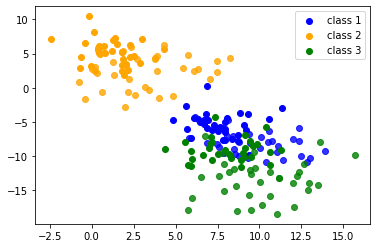

In [91]:
fig, ax = plt.subplots()

for cl, col in zip(range(3), ['blue','orange', 'green']):
    X = Xtr[ytr==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, label='class {}'.format(cl+1))
    X = Xte[yte==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, alpha=0.8,) 

ax.legend(loc=0)

In [92]:
Xtr.shape, Xte.shape

((100, 2), (100, 2))

In [93]:
X_full = np.concatenate([Xtr, Xte])

In [94]:
y_full = np.concatenate([ytr, yte])

In [95]:
X_full = F.normalize(torch.Tensor(X_full)).numpy()

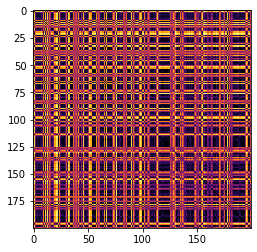

In [96]:
plt.imshow(pairwise_distances(X_full, X_full,), cmap="inferno")

In [97]:
M = pairwise_distances(X_full, X_full, metric="euclidean") + 9999 * np.identity(200)

In [98]:
ot_dom_adap = OptimalTransport(X_full, X_full, M=M, lam=50)

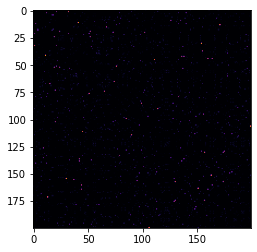

In [99]:
plt.imshow(ot_dom_adap.P, cmap="inferno")

In [100]:
from sklearn.manifold import TSNE

In [101]:
P_red = TSNE().fit_transform(ot_dom_adap.P)

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


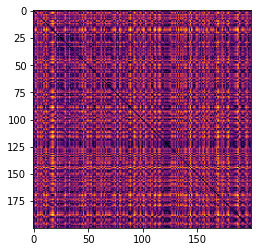

In [102]:
plt.imshow(pairwise_distances(P_red, P_red), cmap='inferno')

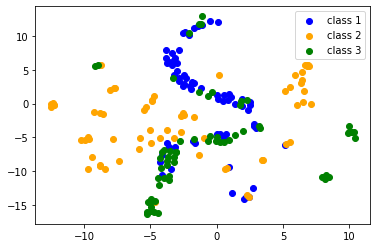

In [103]:
fig, ax = plt.subplots()

for cl, col in zip(range(3), ['blue','orange', 'green']):
    X = P_red[y_full==cl,:]
    ax.scatter(X[:,0], X[:,1], color=col, label='class {}'.format(cl+1))

ax.legend(loc=0)

In [104]:
f_train_cnn = h5py.File('cnn_gnn.hdf5', 'r')

In [105]:
X_cnn_5_train = f_train_cnn['all_feats']
y_cnn_5_train = f_train_cnn['all_labels']

In [106]:
import random
import warnings

In [107]:
train_protoclr_idx = random.sample(range(len(y_cnn_5_train)),500)
train_protoclr_idx.sort()

X_cnn_5_train = X_cnn_5_train[train_protoclr_idx]
y_cnn_5_train = y_cnn_5_train[train_protoclr_idx]

In [115]:
import einops
import seaborn as sns

In [111]:
um = TSNE(n_components=2, random_state=0)
X_cnn_2d_train = um.fit_transform(X_cnn_5_train)

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [112]:
def plot2d(X_2d, y,colors=None, title=None, save_as=None):
    target_ids = range(5)
    labels_train = ["Class {}".format(i) for i in range(1,6)]

    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(11.7,8.27))
    ax = fig.add_subplot(111)
    #colors = 'r', 'g', 'b', 'c', 'm'#, 'y', 'k', 'w', 'orange', 'purple'
    
    markers = "o","D","*","^","P"
    #print(len(colors))
    for i, c, label, marker in zip(target_ids, colors, labels_train, markers):
        ax.scatter(X_2d[y == i, 0],
                   X_2d[y == i, 1], 
                   c=c, label=label, marker=marker)
    #plt.legend()
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(left=True, bottom=True)
    plt.legend(loc='lower right')
    if save_as:
        plt.savefig(save_as, bbox_inches = 'tight',
            pad_inches = 0)
    if title:
        plt.title(title)
    plt.show()

In [113]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

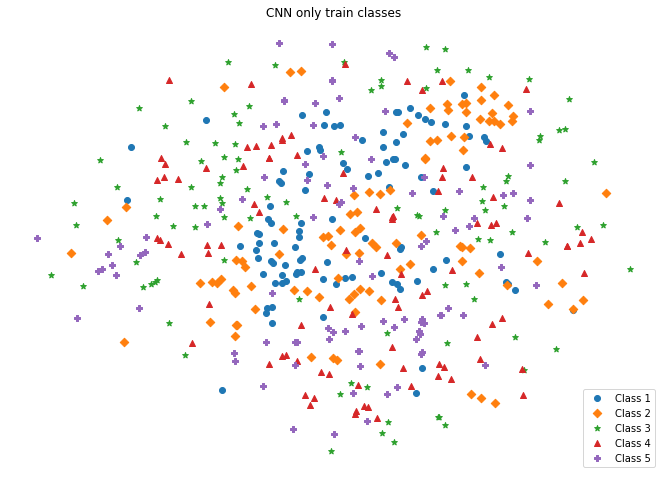

In [116]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2d(X_2d=X_cnn_2d_train, 
           y=y_cnn_5_train,
           colors=colors[:5],
           title="CNN only train classes")

In [152]:
X_cnn = F.normalize(torch.Tensor(X_cnn_2d_train)).numpy()

In [155]:
M = pairwise_distances(X_cnn, X_cnn, metric="euclidean") + 9999 * np.identity(500)

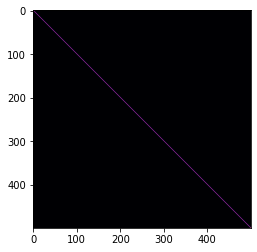

In [156]:
plt.imshow(M, cmap="inferno")

In [158]:
ot_dom_adap = OptimalTransport(X_cnn, X_cnn, M=M, lam=10)

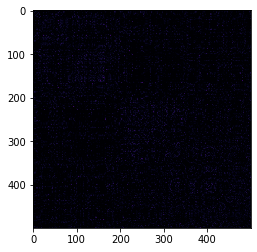

In [160]:
plt.imshow(ot_dom_adap.P, cmap="inferno")

# Analysing our trainable prototypes

In [1]:
import torch
from utils.sup_finetuning import Classifier
import einops

In [2]:
c = Classifier(512, 5)

In [3]:
x = torch.randn(5, 5, 512)

In [49]:
protos = x.mean(1)

In [5]:
x = einops.rearrange(x, "c s e -> (c s) e")
x.shape

torch.Size([25, 512])

In [6]:
c.init_params_from_prototypes(x, 5, 5)

In [7]:
c.fc.weight

Parameter containing:
tensor([[ 0.5491,  1.0450,  0.0804,  ...,  0.5097, -0.7651,  0.5821],
        [-2.0117, -1.7803,  0.5387,  ...,  0.9011,  1.0330,  0.6310],
        [-1.0230, -2.1573,  0.2695,  ...,  0.6123,  1.1428, -0.6075],
        [-0.4493,  0.5694,  1.0883,  ..., -0.2787,  0.0188,  0.2655],
        [ 0.0794, -2.2574, -1.1109,  ..., -0.2563, -0.1068, -0.9108]],
       requires_grad=True)

In [8]:
einops.rearrange(x, "(c s) e -> c s e", c=5, s=5).mean(1) * 2

tensor([[ 0.5491,  1.0450,  0.0804,  ...,  0.5097, -0.7651,  0.5821],
        [-2.0117, -1.7803,  0.5387,  ...,  0.9011,  1.0330,  0.6310],
        [-1.0230, -2.1573,  0.2695,  ...,  0.6123,  1.1428, -0.6075],
        [-0.4493,  0.5694,  1.0883,  ..., -0.2787,  0.0188,  0.2655],
        [ 0.0794, -2.2574, -1.1109,  ..., -0.2563, -0.1068, -0.9108]])

In [11]:
m = torch.nn.utils.weight_norm(c.fc)

In [12]:
m.weight_g

Parameter containing:
tensor([[18.8429],
        [20.0234],
        [19.0432],
        [20.5469],
        [22.1594]], requires_grad=True)

In [15]:
m.weight_v

Parameter containing:
tensor([[ 0.5491,  1.0450,  0.0804,  ...,  0.5097, -0.7651,  0.5821],
        [-2.0117, -1.7803,  0.5387,  ...,  0.9011,  1.0330,  0.6310],
        [-1.0230, -2.1573,  0.2695,  ...,  0.6123,  1.1428, -0.6075],
        [-0.4493,  0.5694,  1.0883,  ..., -0.2787,  0.0188,  0.2655],
        [ 0.0794, -2.2574, -1.1109,  ..., -0.2563, -0.1068, -0.9108]],
       requires_grad=True)

In [27]:
import torch
import pytorch_lightning as pl
from protoclr_obow import PCLROBoW
from clr_gat import CLRGAT
from feature_extractors import feature_extractor
from omegaconf import OmegaConf
from dataloaders import UnlabelledDataset, UnlabelledDataModule
import seaborn as sns
import matplotlib.pyplot as plt
import umap

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
OmegaConf.register_new_resolver("uuid", lambda : "123")

In [17]:
pl.seed_everything(72)

Global seed set to 72


72

In [30]:
sys.modules["bow.feature_extractor"] = feature_extractor

In [31]:
ckp = torch.load("ckpts/cnn.ckpt", map_location="cpu")

In [32]:
state_keys = list(ckp["state_dict"].keys())

In [33]:
for _, k in enumerate(state_keys):
    newkey = f"model.{k}"
    ckp["state_dict"][newkey] = ckp["state_dict"].pop(k)

In [34]:
from clr_gat import CLRGAT

In [35]:
from omegaconf import OmegaConf
OmegaConf.register_new_resolver("uuid", lambda : "123")

ValueError: resolver 'uuid' is already registered

In [36]:
ckp["hyper_parameters"].pop("inner_lr")

0.001

In [37]:
ckp["hyper_parameters"]["mpnn_dev"] = "cpu"
model = CLRGAT(**ckp["hyper_parameters"])

MultiHeadDotProduct


In [39]:
model.load_state_dict(ckp["state_dict"])

<All keys matched successfully>

In [41]:
from dataloaders import get_episode_loader

In [42]:
dl = get_episode_loader("miniimagenet", "../data", 5, 5, 15, 1,"train",)

Supervised data loader for miniimagenet:train.


In [43]:
xs = next(iter(dl))

In [44]:
x = xs["train"][0].squeeze(0)
y = xs["train"][1].squeeze(0)

In [45]:
x.shape, y.shape

(torch.Size([25, 3, 84, 84]), torch.Size([25]))

In [47]:
from utils.sk_finetuning import sinkhorned_finetuning, euclidean_distance, SK

In [65]:
z = model(x)

In [67]:
c = Classifier(1600, 5)

In [68]:
c.init_params_from_prototypes(z, 5, 5)

In [69]:
m = torch.nn.utils.weight_norm(c.fc)

In [70]:
m.weight_v

Parameter containing:
tensor([[-0.0213, -0.0219, -0.0050,  ...,  0.0241, -0.0722,  0.0190],
        [ 0.0060,  0.0049, -0.0036,  ..., -0.0104, -0.0042,  0.0059],
        [ 0.0266, -0.0354,  0.0170,  ...,  0.0504, -0.0120, -0.0091],
        [-0.0247,  0.0256, -0.0163,  ...,  0.0220, -0.0342, -0.0278],
        [ 0.0060,  0.0018, -0.0174,  ..., -0.0229, -0.0622,  0.0200]],
       requires_grad=True)

In [75]:
protos = m.weight_v
protos.shape

torch.Size([5, 1600])

In [77]:
protos = einops.rearrange(protos, "p e -> 1 p e")
z = z.unsqueeze(0)

In [78]:
dists = euclidean_distance(protos, z).squeeze(0)

In [79]:
sk = SK()

In [81]:
scores = sk(dists.t())
scores, scores.shape

(tensor([[2.6501e-09, 4.9425e-04, 9.9902e-01, 1.1603e-04, 3.7000e-04],
         [5.6937e-11, 2.3512e-01, 2.8041e-03, 7.3721e-01, 2.4865e-02],
         [2.1959e-07, 1.3729e-01, 2.1495e-01, 2.8295e-02, 6.1947e-01],
         [5.1008e-08, 5.3235e-01, 4.5724e-01, 4.0467e-06, 1.0399e-02],
         [2.2126e-12, 8.7157e-01, 7.3341e-02, 5.5048e-02, 3.7577e-05],
         [7.5121e-02, 1.7411e-08, 3.1844e-02, 8.9302e-01, 1.6658e-05],
         [9.8494e-01, 1.2671e-07, 1.3343e-02, 5.5661e-04, 1.1648e-03],
         [2.8721e-01, 1.5998e-07, 2.1192e-01, 5.0087e-01, 1.8731e-06],
         [5.0585e-01, 5.4965e-08, 8.5483e-02, 4.3914e-04, 4.0823e-01],
         [5.1849e-03, 6.5397e-09, 4.2641e-02, 1.2462e-06, 9.5217e-01],
         [2.3823e-01, 3.1445e-01, 2.4392e-14, 1.6782e-01, 2.7950e-01],
         [7.7682e-01, 3.6804e-02, 8.6866e-09, 1.8519e-01, 1.1866e-03],
         [2.0936e-01, 7.0634e-01, 2.3060e-08, 1.3723e-04, 8.4169e-02],
         [9.5291e-01, 6.6465e-03, 8.6761e-09, 2.9142e-02, 1.1304e-02],
      

In [83]:
_, preds = torch.max(scores, dim=1)
preds

tensor([2, 3, 4, 1, 1, 3, 0, 3, 0, 4, 1, 0, 1, 0, 4, 4, 1, 2, 4, 1, 2, 2, 0, 3,
        3])

In [87]:
torch.unique(preds, return_counts=True)

(tensor([0, 1, 2, 3, 4]), tensor([5, 6, 4, 5, 5]))

In [90]:
y

tensor([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 4, 4, 4, 4,
        4])